In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

2018-05-08 22:39:38,180 : INFO : 'pattern' package not found; tag filters are not available for English
/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [3]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_batch = train_data[0:100000]
test_batch = test_data[0:50000]

In [4]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy                     %s' % accuracy_score(target, predictions))
    print('explained_variance_score     %s' % explained_variance_score(target, predictions))
    print('mean_absolute_error          %s' % mean_absolute_error(target, predictions))
    print('mean_squared_error           %s' % mean_squared_error(target, predictions))
    print('mean_squared_log_error       %s' % mean_squared_log_error(target, predictions))
    print('r2_score                     %s' % r2_score(target, predictions))
    print()
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
def plot_confusion_matrix(cm, title='Матрица ошибок', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = pd.unique(train_batch.stars)
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('Исходные метки')
    plt.xlabel('Полученные метки')
    
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data.text)
    predictions = classifier.predict(data_features)
    target = data.stars
    evaluate_prediction(predictions, target)

In [5]:
import re
contractions = re.compile(r"'|-|\"")
# all non alphanumeric
symbols = re.compile(r'(\W+)', re.U)
# single character removal
singles = re.compile(r'(\s\S\s)', re.I|re.U)
# separators (any whitespace)
seps = re.compile(r'\s+')

# cleaner (order matters)
def clean(text): 
    text = text.lower()
    text = contractions.sub('', text)
    text = symbols.sub(r' \1 ', text)
    text = singles.sub(' ', text)
    text = seps.sub(' ', text)
    return text

# sentence splitter
alteos = re.compile(r'([!\?])')
def sentences(l):
    l = alteos.sub(r' \1 .', l).rstrip("(\.)*\n")
    return l.split(".")

In [6]:
def plots(label):
    my_df = None
    if label=='training':
        my_df = train_batch
    else:
        my_df = test_batch
    for i, row in my_df.iterrows():
        yield {'y':row.stars,\
        'x':[clean(s).split() for s in sentences(row.text)]}

In [7]:
%%time
# The corpus is small so can be read into memory
revtrain = list(plots("training"))
revtest = list(plots("test"))

CPU times: user 1min 2s, sys: 763 ms, total: 1min 3s
Wall time: 1min 3s


In [8]:
# shuffle training set for unbiased word2vec training
np.random.shuffle(revtrain)

In [9]:
my_tags = pd.unique(train_batch.stars)

In [10]:
def tag_sentences(reviews, stars=my_tags):
    for r in reviews:
#         if r['y'] in stars:
        for s in r['x']:
            yield s

In [11]:
next(tag_sentences(revtrain, my_tags[0]))

['just', 'be', 'you', 'at', 'lucky', 'lous']

In [12]:
%%time 
## training
from gensim.models import Word2Vec
import multiprocessing

## create a w2v learner
basemodel = Word2Vec(
    workers=multiprocessing.cpu_count() - 1, # use your cores
    iter=100, # iter = sweeps of SGD through the data; more is better
    hs=1, negative=0, # we only have scoring for the hierarchical softmax setup    
    )
print(basemodel)
basemodel.build_vocab(tag_sentences(revtrain)) 
from copy import deepcopy
genremodels = [deepcopy(basemodel) for i in range(len(my_tags))]
for i in range(len(my_tags)):
    slist = list(tag_sentences(revtrain, my_tags[i]))
    print(my_tags[i], "star (", len(slist), ")")
    genremodels[i].train( slist, total_examples=len(slist), epochs=20 )

2018-05-08 22:42:53,222 : INFO : collecting all words and their counts
2018-05-08 22:42:53,224 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-08 22:42:53,273 : INFO : PROGRESS: at sentence #10000, processed 110582 words, keeping 10121 word types
2018-05-08 22:42:53,304 : INFO : PROGRESS: at sentence #20000, processed 222028 words, keeping 14694 word types
2018-05-08 22:42:53,338 : INFO : PROGRESS: at sentence #30000, processed 329185 words, keeping 17993 word types
2018-05-08 22:42:53,378 : INFO : PROGRESS: at sentence #40000, processed 439843 words, keeping 20898 word types
2018-05-08 22:42:53,411 : INFO : PROGRESS: at sentence #50000, processed 546543 words, keeping 23302 word types


Word2Vec(vocab=0, size=100, alpha=0.025)


2018-05-08 22:42:53,449 : INFO : PROGRESS: at sentence #60000, processed 657304 words, keeping 25718 word types
2018-05-08 22:42:53,478 : INFO : PROGRESS: at sentence #70000, processed 764271 words, keeping 27944 word types
2018-05-08 22:42:53,514 : INFO : PROGRESS: at sentence #80000, processed 872037 words, keeping 29731 word types
2018-05-08 22:42:53,548 : INFO : PROGRESS: at sentence #90000, processed 982507 words, keeping 31542 word types
2018-05-08 22:42:53,579 : INFO : PROGRESS: at sentence #100000, processed 1090013 words, keeping 33085 word types
2018-05-08 22:42:53,605 : INFO : PROGRESS: at sentence #110000, processed 1200133 words, keeping 34727 word types
2018-05-08 22:42:53,641 : INFO : PROGRESS: at sentence #120000, processed 1306652 words, keeping 36104 word types
2018-05-08 22:42:53,682 : INFO : PROGRESS: at sentence #130000, processed 1414835 words, keeping 37639 word types
2018-05-08 22:42:53,717 : INFO : PROGRESS: at sentence #140000, processed 1521736 words, keeping

2018-05-08 22:42:55,947 : INFO : PROGRESS: at sentence #780000, processed 8512857 words, keeping 94446 word types
2018-05-08 22:42:55,980 : INFO : PROGRESS: at sentence #790000, processed 8617166 words, keeping 95076 word types
2018-05-08 22:42:56,022 : INFO : PROGRESS: at sentence #800000, processed 8725622 words, keeping 95683 word types
2018-05-08 22:42:56,062 : INFO : PROGRESS: at sentence #810000, processed 8832296 words, keeping 96283 word types
2018-05-08 22:42:56,090 : INFO : PROGRESS: at sentence #820000, processed 8937929 words, keeping 96841 word types
2018-05-08 22:42:56,122 : INFO : PROGRESS: at sentence #830000, processed 9050365 words, keeping 97408 word types
2018-05-08 22:42:56,149 : INFO : PROGRESS: at sentence #840000, processed 9159110 words, keeping 97986 word types
2018-05-08 22:42:56,183 : INFO : PROGRESS: at sentence #850000, processed 9270283 words, keeping 98632 word types
2018-05-08 22:42:56,210 : INFO : PROGRESS: at sentence #860000, processed 9379568 words,

1 star ( 986290 )


2018-05-08 22:43:02,928 : INFO : EPOCH 1 - PROGRESS: at 8.28% examples, 675268 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:43:03,929 : INFO : EPOCH 1 - PROGRESS: at 16.90% examples, 692206 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:43:04,930 : INFO : EPOCH 1 - PROGRESS: at 25.96% examples, 710278 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:43:05,936 : INFO : EPOCH 1 - PROGRESS: at 35.27% examples, 722458 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:43:06,937 : INFO : EPOCH 1 - PROGRESS: at 43.91% examples, 721369 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:43:07,939 : INFO : EPOCH 1 - PROGRESS: at 52.63% examples, 720493 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:43:08,953 : INFO : EPOCH 1 - PROGRESS: at 60.99% examples, 714189 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:43:09,956 : INFO : EPOCH 1 - PROGRESS: at 69.22% examples, 708621 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:43:10,969 : INFO : EPOCH 1 - PROGRESS: at 78.23% examples, 711048 words/s, in_qsize

2018-05-08 22:44:01,644 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:44:01,645 : INFO : EPOCH - 5 : training on 10765626 raw words (8223964 effective words) took 12.5s, 657806 effective words/s
2018-05-08 22:44:02,653 : INFO : EPOCH 6 - PROGRESS: at 7.63% examples, 625532 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:44:03,659 : INFO : EPOCH 6 - PROGRESS: at 15.52% examples, 635724 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:44:04,660 : INFO : EPOCH 6 - PROGRESS: at 23.93% examples, 655003 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:44:05,672 : INFO : EPOCH 6 - PROGRESS: at 32.28% examples, 660918 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:44:06,679 : INFO : EPOCH 6 - PROGRESS: at 40.96% examples, 671105 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:44:07,694 : INFO : EPOCH 6 - PROGRESS: at 49.49% examples, 674650 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:44:08,699 : INFO : EPOCH 6 - PROGRESS: at 58.20% examples, 680158 words/s, in_q

2018-05-08 22:45:02,501 : INFO : EPOCH 10 - PROGRESS: at 84.27% examples, 571142 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:45:03,519 : INFO : EPOCH 10 - PROGRESS: at 91.86% examples, 575124 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:45:04,536 : INFO : EPOCH 10 - PROGRESS: at 99.77% examples, 579662 words/s, in_qsize 3, out_qsize 0
2018-05-08 22:45:04,541 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 22:45:04,548 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 22:45:04,553 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:45:04,554 : INFO : EPOCH - 10 : training on 10765626 raw words (8224926 effective words) took 14.2s, 580295 effective words/s
2018-05-08 22:45:05,577 : INFO : EPOCH 11 - PROGRESS: at 7.44% examples, 607682 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:45:06,577 : INFO : EPOCH 11 - PROGRESS: at 14.62% examples, 597787 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:45:0

2018-05-08 22:46:00,874 : INFO : EPOCH 15 - PROGRESS: at 7.24% examples, 591336 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:46:01,888 : INFO : EPOCH 15 - PROGRESS: at 14.62% examples, 593019 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:46:02,895 : INFO : EPOCH 15 - PROGRESS: at 22.10% examples, 600051 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:46:03,899 : INFO : EPOCH 15 - PROGRESS: at 29.47% examples, 601985 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:46:04,910 : INFO : EPOCH 15 - PROGRESS: at 37.09% examples, 605436 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:46:05,914 : INFO : EPOCH 15 - PROGRESS: at 44.48% examples, 605960 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:46:06,919 : INFO : EPOCH 15 - PROGRESS: at 51.69% examples, 604096 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:46:07,922 : INFO : EPOCH 15 - PROGRESS: at 59.22% examples, 605554 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:46:08,926 : INFO : EPOCH 15 - PROGRESS: at 66.98% examples, 608406 words/s,

2018-05-08 22:47:01,789 : INFO : EPOCH 19 - PROGRESS: at 7.63% examples, 613794 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:47:02,793 : INFO : EPOCH 19 - PROGRESS: at 15.34% examples, 622833 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:03,804 : INFO : EPOCH 19 - PROGRESS: at 23.38% examples, 634131 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:04,806 : INFO : EPOCH 19 - PROGRESS: at 31.23% examples, 637211 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:05,818 : INFO : EPOCH 19 - PROGRESS: at 39.11% examples, 638175 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:06,832 : INFO : EPOCH 19 - PROGRESS: at 47.48% examples, 644832 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:07,834 : INFO : EPOCH 19 - PROGRESS: at 55.84% examples, 650587 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:47:08,842 : INFO : EPOCH 19 - PROGRESS: at 64.62% examples, 659070 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:09,860 : INFO : EPOCH 19 - PROGRESS: at 73.36% examples, 664206 words/s,

4 star ( 986290 )


2018-05-08 22:47:26,683 : INFO : EPOCH 1 - PROGRESS: at 8.26% examples, 678447 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:27,692 : INFO : EPOCH 1 - PROGRESS: at 16.23% examples, 664602 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:28,714 : INFO : EPOCH 1 - PROGRESS: at 24.39% examples, 662101 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:47:29,733 : INFO : EPOCH 1 - PROGRESS: at 32.67% examples, 662984 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:30,736 : INFO : EPOCH 1 - PROGRESS: at 38.36% examples, 625161 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:31,759 : INFO : EPOCH 1 - PROGRESS: at 43.82% examples, 594145 words/s, in_qsize 6, out_qsize 2
2018-05-08 22:47:32,761 : INFO : EPOCH 1 - PROGRESS: at 49.85% examples, 580074 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:47:33,762 : INFO : EPOCH 1 - PROGRESS: at 55.93% examples, 569529 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:47:34,765 : INFO : EPOCH 1 - PROGRESS: at 62.02% examples, 562127 words/s, in_qsize

2018-05-08 22:48:30,658 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 22:48:30,670 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 22:48:30,675 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:48:30,676 : INFO : EPOCH - 4 : training on 10765626 raw words (8224020 effective words) took 16.0s, 513453 effective words/s
2018-05-08 22:48:31,707 : INFO : EPOCH 5 - PROGRESS: at 6.19% examples, 501784 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:48:32,710 : INFO : EPOCH 5 - PROGRESS: at 12.86% examples, 520908 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:48:33,733 : INFO : EPOCH 5 - PROGRESS: at 19.50% examples, 526464 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:48:34,745 : INFO : EPOCH 5 - PROGRESS: at 25.96% examples, 526755 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:48:35,749 : INFO : EPOCH 5 - PROGRESS: at 32.18% examples, 523152 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:48:36,749 

2018-05-08 22:49:30,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:49:30,448 : INFO : EPOCH - 8 : training on 10765626 raw words (8224975 effective words) took 14.5s, 565571 effective words/s
2018-05-08 22:49:31,464 : INFO : EPOCH 9 - PROGRESS: at 6.39% examples, 524277 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:49:32,482 : INFO : EPOCH 9 - PROGRESS: at 12.86% examples, 521199 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:49:33,498 : INFO : EPOCH 9 - PROGRESS: at 19.03% examples, 515262 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:49:34,510 : INFO : EPOCH 9 - PROGRESS: at 25.59% examples, 520379 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:49:35,526 : INFO : EPOCH 9 - PROGRESS: at 31.61% examples, 513875 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:49:36,539 : INFO : EPOCH 9 - PROGRESS: at 38.19% examples, 517389 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:49:37,540 : INFO : EPOCH 9 - PROGRESS: at 44.76% examples, 520883 words/s, in_q

2018-05-08 22:50:31,241 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:50:31,242 : INFO : EPOCH - 12 : training on 10765626 raw words (8224810 effective words) took 14.4s, 571217 effective words/s
2018-05-08 22:50:32,267 : INFO : EPOCH 13 - PROGRESS: at 7.44% examples, 600386 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:50:33,280 : INFO : EPOCH 13 - PROGRESS: at 14.43% examples, 582834 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:50:34,297 : INFO : EPOCH 13 - PROGRESS: at 22.10% examples, 596313 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:50:35,299 : INFO : EPOCH 13 - PROGRESS: at 29.83% examples, 606973 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:50:36,315 : INFO : EPOCH 13 - PROGRESS: at 37.55% examples, 610308 words/s, in_qsize 6, out_qsize 1
2018-05-08 22:50:37,321 : INFO : EPOCH 13 - PROGRESS: at 45.22% examples, 613669 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:50:38,328 : INFO : EPOCH 13 - PROGRESS: at 52.81% examples, 614821 words

2018-05-08 22:51:30,519 : INFO : EPOCH 17 - PROGRESS: at 54.22% examples, 631946 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:51:31,534 : INFO : EPOCH 17 - PROGRESS: at 62.02% examples, 631912 words/s, in_qsize 6, out_qsize 1
2018-05-08 22:51:32,541 : INFO : EPOCH 17 - PROGRESS: at 70.12% examples, 634884 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:51:33,549 : INFO : EPOCH 17 - PROGRESS: at 78.15% examples, 636545 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:51:34,575 : INFO : EPOCH 17 - PROGRESS: at 86.10% examples, 636225 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:51:35,577 : INFO : EPOCH 17 - PROGRESS: at 93.34% examples, 633392 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:51:36,463 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 22:51:36,465 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 22:51:36,473 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:51:36,474 : INFO : EPOCH - 17

5 star ( 986290 )


2018-05-08 22:52:17,081 : INFO : EPOCH 1 - PROGRESS: at 8.46% examples, 693443 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:52:18,088 : INFO : EPOCH 1 - PROGRESS: at 16.79% examples, 687750 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:52:19,102 : INFO : EPOCH 1 - PROGRESS: at 25.13% examples, 684183 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:52:20,108 : INFO : EPOCH 1 - PROGRESS: at 34.04% examples, 695208 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:52:21,112 : INFO : EPOCH 1 - PROGRESS: at 41.42% examples, 677828 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:52:22,120 : INFO : EPOCH 1 - PROGRESS: at 49.12% examples, 669669 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:52:23,121 : INFO : EPOCH 1 - PROGRESS: at 57.68% examples, 674106 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:52:24,134 : INFO : EPOCH 1 - PROGRESS: at 64.07% examples, 654656 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:52:25,151 : INFO : EPOCH 1 - PROGRESS: at 69.49% examples, 630076 words/s, in_qsize

2018-05-08 22:53:18,155 : INFO : EPOCH 5 - PROGRESS: at 75.60% examples, 683936 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:53:19,156 : INFO : EPOCH 5 - PROGRESS: at 83.80% examples, 681900 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:53:20,168 : INFO : EPOCH 5 - PROGRESS: at 91.77% examples, 679633 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:53:21,170 : INFO : EPOCH 5 - PROGRESS: at 99.37% examples, 675051 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:53:21,221 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 22:53:21,233 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 22:53:21,236 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:53:21,237 : INFO : EPOCH - 5 : training on 10765626 raw words (8225265 effective words) took 12.2s, 675440 effective words/s
2018-05-08 22:53:22,246 : INFO : EPOCH 6 - PROGRESS: at 5.10% examples, 419558 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:53:23,247 

2018-05-08 22:54:18,144 : INFO : EPOCH 9 - PROGRESS: at 73.92% examples, 671346 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:54:19,151 : INFO : EPOCH 9 - PROGRESS: at 81.65% examples, 666310 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:54:20,163 : INFO : EPOCH 9 - PROGRESS: at 90.14% examples, 668825 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:54:21,174 : INFO : EPOCH 9 - PROGRESS: at 98.62% examples, 671032 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:54:21,299 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 22:54:21,302 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 22:54:21,310 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:54:21,311 : INFO : EPOCH - 9 : training on 10765626 raw words (8225085 effective words) took 12.2s, 672633 effective words/s
2018-05-08 22:54:22,335 : INFO : EPOCH 10 - PROGRESS: at 8.18% examples, 662006 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:54:23,348

2018-05-08 22:55:15,946 : INFO : EPOCH 14 - PROGRESS: at 23.64% examples, 643321 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:55:16,962 : INFO : EPOCH 14 - PROGRESS: at 31.32% examples, 638218 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:55:17,976 : INFO : EPOCH 14 - PROGRESS: at 38.74% examples, 630967 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:55:18,982 : INFO : EPOCH 14 - PROGRESS: at 46.23% examples, 628304 words/s, in_qsize 5, out_qsize 1
2018-05-08 22:55:20,006 : INFO : EPOCH 14 - PROGRESS: at 53.57% examples, 622588 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:55:21,009 : INFO : EPOCH 14 - PROGRESS: at 60.06% examples, 611396 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:55:22,027 : INFO : EPOCH 14 - PROGRESS: at 66.39% examples, 600020 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:55:23,046 : INFO : EPOCH 14 - PROGRESS: at 72.81% examples, 591689 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:55:24,061 : INFO : EPOCH 14 - PROGRESS: at 79.27% examples, 585075 words/s

2018-05-08 22:56:16,621 : INFO : EPOCH 18 - PROGRESS: at 32.18% examples, 524761 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:56:17,629 : INFO : EPOCH 18 - PROGRESS: at 38.56% examples, 524365 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:56:18,661 : INFO : EPOCH 18 - PROGRESS: at 45.13% examples, 524534 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:56:19,674 : INFO : EPOCH 18 - PROGRESS: at 51.60% examples, 524829 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:56:20,684 : INFO : EPOCH 18 - PROGRESS: at 58.02% examples, 524373 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:56:21,687 : INFO : EPOCH 18 - PROGRESS: at 64.44% examples, 524348 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:56:22,706 : INFO : EPOCH 18 - PROGRESS: at 70.86% examples, 523666 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:56:23,711 : INFO : EPOCH 18 - PROGRESS: at 77.29% examples, 523755 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:56:24,723 : INFO : EPOCH 18 - PROGRESS: at 83.89% examples, 524056 words/s

2 star ( 986290 )


2018-05-08 22:57:01,619 : INFO : EPOCH 1 - PROGRESS: at 6.28% examples, 516514 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:57:02,628 : INFO : EPOCH 1 - PROGRESS: at 12.76% examples, 519135 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:57:03,635 : INFO : EPOCH 1 - PROGRESS: at 19.31% examples, 525614 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:57:04,639 : INFO : EPOCH 1 - PROGRESS: at 25.41% examples, 519576 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:57:05,640 : INFO : EPOCH 1 - PROGRESS: at 31.99% examples, 523796 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:57:06,643 : INFO : EPOCH 1 - PROGRESS: at 38.19% examples, 521578 words/s, in_qsize 6, out_qsize 1
2018-05-08 22:57:07,652 : INFO : EPOCH 1 - PROGRESS: at 44.38% examples, 519477 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:57:08,663 : INFO : EPOCH 1 - PROGRESS: at 50.95% examples, 521615 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:57:09,674 : INFO : EPOCH 1 - PROGRESS: at 57.32% examples, 520625 words/s, in_qsize

2018-05-08 22:58:05,710 : INFO : EPOCH 4 - PROGRESS: at 91.21% examples, 495088 words/s, in_qsize 4, out_qsize 1
2018-05-08 22:58:06,718 : INFO : EPOCH 4 - PROGRESS: at 97.12% examples, 494488 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:58:07,185 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 22:58:07,200 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 22:58:07,201 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:58:07,202 : INFO : EPOCH - 4 : training on 10765626 raw words (8224946 effective words) took 16.6s, 494102 effective words/s
2018-05-08 22:58:08,220 : INFO : EPOCH 5 - PROGRESS: at 6.01% examples, 492953 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:58:09,237 : INFO : EPOCH 5 - PROGRESS: at 12.38% examples, 502013 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:58:10,238 : INFO : EPOCH 5 - PROGRESS: at 18.39% examples, 499844 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:58:11,265 

2018-05-08 22:59:05,896 : INFO : EPOCH 8 - PROGRESS: at 80.05% examples, 501473 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:59:06,910 : INFO : EPOCH 8 - PROGRESS: at 86.10% examples, 500633 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:59:07,945 : INFO : EPOCH 8 - PROGRESS: at 92.04% examples, 499187 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:59:08,946 : INFO : EPOCH 8 - PROGRESS: at 97.98% examples, 498454 words/s, in_qsize 6, out_qsize 0
2018-05-08 22:59:09,241 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 22:59:09,250 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 22:59:09,257 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 22:59:09,258 : INFO : EPOCH - 8 : training on 10765626 raw words (8225458 effective words) took 16.5s, 499015 effective words/s
2018-05-08 22:59:10,290 : INFO : EPOCH 9 - PROGRESS: at 6.01% examples, 486079 words/s, in_qsize 5, out_qsize 0
2018-05-08 22:59:11,304 

2018-05-08 23:00:06,106 : INFO : EPOCH 12 - PROGRESS: at 42.88% examples, 501490 words/s, in_qsize 4, out_qsize 1
2018-05-08 23:00:07,115 : INFO : EPOCH 12 - PROGRESS: at 48.94% examples, 500355 words/s, in_qsize 6, out_qsize 0
2018-05-08 23:00:08,129 : INFO : EPOCH 12 - PROGRESS: at 54.80% examples, 497333 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:00:09,145 : INFO : EPOCH 12 - PROGRESS: at 60.63% examples, 494887 words/s, in_qsize 6, out_qsize 1
2018-05-08 23:00:10,172 : INFO : EPOCH 12 - PROGRESS: at 66.39% examples, 491697 words/s, in_qsize 6, out_qsize 0
2018-05-08 23:00:11,173 : INFO : EPOCH 12 - PROGRESS: at 72.53% examples, 492656 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:00:12,178 : INFO : EPOCH 12 - PROGRESS: at 78.60% examples, 492746 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:00:13,178 : INFO : EPOCH 12 - PROGRESS: at 85.10% examples, 495153 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:00:14,186 : INFO : EPOCH 12 - PROGRESS: at 91.31% examples, 496436 words/s

2018-05-08 23:01:06,900 : INFO : EPOCH 16 - PROGRESS: at 25.77% examples, 523614 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:01:07,909 : INFO : EPOCH 16 - PROGRESS: at 32.09% examples, 521591 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:01:08,931 : INFO : EPOCH 16 - PROGRESS: at 38.74% examples, 524373 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:01:09,936 : INFO : EPOCH 16 - PROGRESS: at 45.40% examples, 527568 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:01:10,940 : INFO : EPOCH 16 - PROGRESS: at 51.25% examples, 521625 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:01:11,947 : INFO : EPOCH 16 - PROGRESS: at 57.03% examples, 515800 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:01:12,963 : INFO : EPOCH 16 - PROGRESS: at 63.50% examples, 516791 words/s, in_qsize 4, out_qsize 1
2018-05-08 23:01:13,966 : INFO : EPOCH 16 - PROGRESS: at 69.58% examples, 514788 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:01:14,972 : INFO : EPOCH 16 - PROGRESS: at 76.63% examples, 519952 words/s

2018-05-08 23:02:07,988 : INFO : EPOCH 20 - PROGRESS: at 95.48% examples, 649226 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:02:08,558 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 23:02:08,570 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 23:02:08,581 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 23:02:08,582 : INFO : EPOCH - 20 : training on 10765626 raw words (8224288 effective words) took 12.7s, 648059 effective words/s
2018-05-08 23:02:08,583 : INFO : training on a 215312520 raw words (164506656 effective words) took 308.0s, 534155 effective words/s
2018-05-08 23:02:08,803 : INFO : training model with 3 workers on 29272 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 negative=0 window=5


3 star ( 986290 )


2018-05-08 23:02:09,833 : INFO : EPOCH 1 - PROGRESS: at 8.36% examples, 677673 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:02:10,834 : INFO : EPOCH 1 - PROGRESS: at 16.23% examples, 663262 words/s, in_qsize 6, out_qsize 0
2018-05-08 23:02:11,838 : INFO : EPOCH 1 - PROGRESS: at 24.21% examples, 660173 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:02:12,841 : INFO : EPOCH 1 - PROGRESS: at 32.27% examples, 660542 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:02:13,842 : INFO : EPOCH 1 - PROGRESS: at 39.95% examples, 655100 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:02:14,842 : INFO : EPOCH 1 - PROGRESS: at 48.02% examples, 656705 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:02:15,857 : INFO : EPOCH 1 - PROGRESS: at 56.02% examples, 655152 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:02:16,864 : INFO : EPOCH 1 - PROGRESS: at 64.07% examples, 655566 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:02:17,881 : INFO : EPOCH 1 - PROGRESS: at 71.81% examples, 651930 words/s, in_qsize

2018-05-08 23:03:10,582 : INFO : EPOCH 5 - PROGRESS: at 63.05% examples, 642274 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:03:11,583 : INFO : EPOCH 5 - PROGRESS: at 70.51% examples, 638642 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:03:12,594 : INFO : EPOCH 5 - PROGRESS: at 78.33% examples, 638255 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:03:13,604 : INFO : EPOCH 5 - PROGRESS: at 86.47% examples, 640019 words/s, in_qsize 6, out_qsize 1
2018-05-08 23:03:14,631 : INFO : EPOCH 5 - PROGRESS: at 94.44% examples, 640531 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:03:15,312 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 23:03:15,316 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 23:03:15,317 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 23:03:15,318 : INFO : EPOCH - 5 : training on 10765626 raw words (8224565 effective words) took 12.8s, 641610 effective words/s
2018-05-08 23:03:16,333

2018-05-08 23:04:09,431 : INFO : EPOCH 10 - PROGRESS: at 23.93% examples, 646448 words/s, in_qsize 6, out_qsize 1
2018-05-08 23:04:10,445 : INFO : EPOCH 10 - PROGRESS: at 31.99% examples, 648197 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:04:11,448 : INFO : EPOCH 10 - PROGRESS: at 40.21% examples, 653975 words/s, in_qsize 6, out_qsize 0
2018-05-08 23:04:12,453 : INFO : EPOCH 10 - PROGRESS: at 48.38% examples, 656512 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:04:13,457 : INFO : EPOCH 10 - PROGRESS: at 56.41% examples, 656116 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:04:14,462 : INFO : EPOCH 10 - PROGRESS: at 64.34% examples, 655704 words/s, in_qsize 6, out_qsize 0
2018-05-08 23:04:15,473 : INFO : EPOCH 10 - PROGRESS: at 72.36% examples, 654955 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:04:16,492 : INFO : EPOCH 10 - PROGRESS: at 80.23% examples, 652463 words/s, in_qsize 6, out_qsize 0
2018-05-08 23:04:17,494 : INFO : EPOCH 10 - PROGRESS: at 87.31% examples, 645823 words/s

2018-05-08 23:05:10,094 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 23:05:10,099 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 23:05:10,105 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-08 23:05:10,106 : INFO : EPOCH - 14 : training on 10765626 raw words (8224688 effective words) took 12.8s, 641144 effective words/s
2018-05-08 23:05:11,128 : INFO : EPOCH 15 - PROGRESS: at 6.49% examples, 530279 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:05:12,130 : INFO : EPOCH 15 - PROGRESS: at 12.18% examples, 498023 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:05:13,133 : INFO : EPOCH 15 - PROGRESS: at 19.59% examples, 534875 words/s, in_qsize 4, out_qsize 1
2018-05-08 23:05:14,137 : INFO : EPOCH 15 - PROGRESS: at 26.04% examples, 534140 words/s, in_qsize 6, out_qsize 1
2018-05-08 23:05:15,150 : INFO : EPOCH 15 - PROGRESS: at 33.41% examples, 546313 words/s, in_qsize 6, out_qsize 0
2018-05-08 23:05:1

2018-05-08 23:06:07,875 : INFO : EPOCH 19 - PROGRESS: at 47.48% examples, 647448 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:06:08,888 : INFO : EPOCH 19 - PROGRESS: at 55.37% examples, 646396 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:06:09,891 : INFO : EPOCH 19 - PROGRESS: at 63.23% examples, 646374 words/s, in_qsize 6, out_qsize 0
2018-05-08 23:06:10,912 : INFO : EPOCH 19 - PROGRESS: at 70.96% examples, 643436 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:06:11,916 : INFO : EPOCH 19 - PROGRESS: at 77.67% examples, 633830 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:06:12,920 : INFO : EPOCH 19 - PROGRESS: at 85.71% examples, 635690 words/s, in_qsize 5, out_qsize 0
2018-05-08 23:06:13,928 : INFO : EPOCH 19 - PROGRESS: at 93.52% examples, 636372 words/s, in_qsize 6, out_qsize 1
2018-05-08 23:06:14,696 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-08 23:06:14,709 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-08 23:06:14,

CPU times: user 59min 40s, sys: 17.8 s, total: 59min 58s
Wall time: 23min 34s


In [13]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""


def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob

In [14]:
%%time
## predict
probs = docprob( [r['x'] for r in revtest], genremodels )  
predictions = probs.idxmax(axis=1).apply(lambda x: my_tags[x])

2018-05-08 23:07:00,968 : INFO : scoring sentences with 3 workers on 29272 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=0
2018-05-08 23:07:01,970 : INFO : PROGRESS: at 7070000.00% sentences, 70671 sentences/s
2018-05-08 23:07:02,974 : INFO : PROGRESS: at 14870000.00% sentences, 74161 sentences/s
2018-05-08 23:07:03,975 : INFO : PROGRESS: at 22670000.00% sentences, 75423 sentences/s
2018-05-08 23:07:04,977 : INFO : PROGRESS: at 30450000.00% sentences, 75977 sentences/s
2018-05-08 23:07:05,978 : INFO : PROGRESS: at 38270000.00% sentences, 76398 sentences/s
2018-05-08 23:07:06,981 : INFO : PROGRESS: at 45960000.00% sentences, 76451 sentences/s
2018-05-08 23:07:07,332 : INFO : reached end of input; waiting to finish 9 outstanding jobs
2018-05-08 23:07:07,344 : INFO : scoring 487389 sentences took 6.4s, 76458 sentences/s
2018-05-08 23:07:07,344 : INFO : scoring sentences with 3 workers on 29272 vocabulary and 100 features, using sg=0 hs=1 sample=0.001 and negative=

CPU times: user 56.4 s, sys: 6.19 s, total: 1min 2s
Wall time: 31.8 s


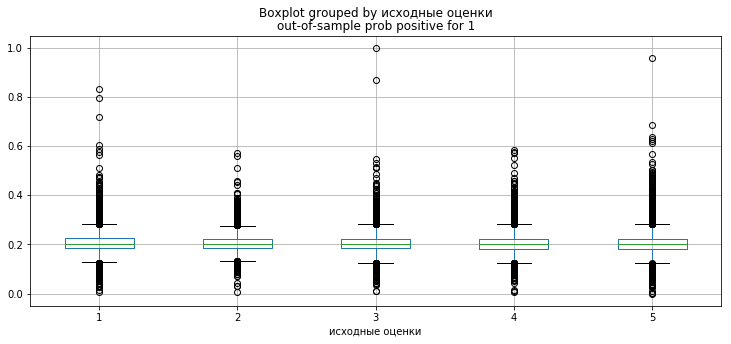

In [15]:
tag_index = 0
col_name = "out-of-sample prob positive for " + str(my_tags[tag_index])
probpos = pd.DataFrame({col_name:probs[[tag_index]].sum(axis=1), 
                        "исходные оценки": [r['y'] for r in revtest]})
probpos.boxplot(col_name,by="исходные оценки", figsize=(12,5))

In [16]:
target = [r['y'] for r in revtest]

accuracy                     0.21044
explained_variance_score     -1.0099401266788108
mean_absolute_error          1.71038
mean_squared_error           4.63114
mean_squared_log_error       0.3363401951160682
r2_score                     -1.2710851897045203

confusion matrix
 [[1774  827 1548 1410 1315]
 [ 995  470  960  810  821]
 [1429  723 1339 1236 1195]
 [2766 1582 2440 2486 2434]
 [4995 3051 4451 4490 4453]]
(row=expected, col=predicted)


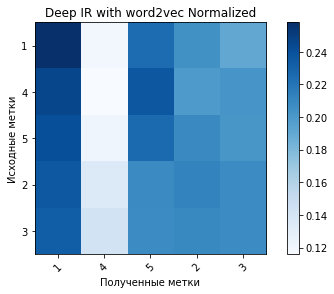

In [17]:
evaluate_prediction(predictions, target, "Deep IR with word2vec")